In [1]:
fpath = 'cut_newclassification_TLS.csv'
fpath_result = 'output_multilayer/multilayers_ALS(TLS)_0.3_segmentation.csv'

In [2]:
# Author: Hamid Hamraz (hhamraz@cs.uky.edu)
# 2016, Department of Computer Science, University of Kentucky

import sys
import numpy
from operator import itemgetter

import fpclib.util as util
import fpclib.forest as forest
from fpclib.constants import *
import fpclib.crownSegmenter as crw_seg

# Loading the point cloud.  We assign 'True" to the skipHeader parameter, to skip the first line of the input.
cloud = util.loadData(fpath, skipHeader=True)

# Indexing the point cloud to a grid.  Normalized height of the LiDAR points are determined here.
grid = forest.indexPointCloud(cloud)

# Lower vegetation and ground points are removed since normalized heights were already calculated.
forest.excludeLowPoints(grid)

# If the highest point of the grid cell is not a first return, that grid cell won't be used.  
# This helps decrease non-necessary surface variability.
forest.excludeNonFirstReturnSurfaces(grid)

# Now, we segment the point cloud to individual trees.
# multilayer=0 means that the DSM-based segmentation is used. 
# multilayer=1 means multilayer segmentation with the regional layering method is used. 
# multilayer=2 means multilayer segmentation with the local layering method is used.  
# For the multilayer segmentations, if merging crowns across layers is desired, merge=True should be used.
# trees variable is a list of trees, where each tree is actually a list of LiDAR points.
# noise variable is a list of small noise pieces , where each piece is actually a list of LiDAR points.
trees, noise = crw_seg.segmentCanopy(grid, multilayer= 0, merge=False)

print "Number of trees:", len(trees)

# 2D Visualizing the segmented crowns in distinct colors aerially.
# If the multilayer segmentation was performed, this visualization may look wierd because it paints layers on top of each other.
util.scatterPlot(trees, X, Y, popup= False, fname="output_multilayer/multilayers_ALS(TLS)_0.3_segmentation.png")
# If the path to a file is provided, the segmentation result is written to that file.
if len(sys.argv) > 2:
	util.outputPlotResult(trees, noise, fpath_result)

456999 data points loaded.
Number of trees: 110


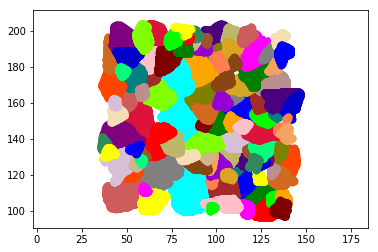

In [3]:
util.scatterPlot(trees, X, Y)

Resaved the csv file to txt

Find each segment tree's polygon and draw the polygon into the raster as well as calculate the raster

In [4]:
import numpy as np
import cv2
import numpy as np
import pylab as plt
%matplotlib inline
from math import sqrt

In [77]:
m = 0
n = 0
start = []
end = []
for i, line in enumerate(open('output_multilayer/multilayers_ALS(TLS)_segmentation.txt', 'r').readlines()):
    
    if 'Boundary Points:' in line:
        m = m + 1
        start.append(i)
    if 'Entire Set of Points:' in line:
        n = n + 1
        end.append(i)

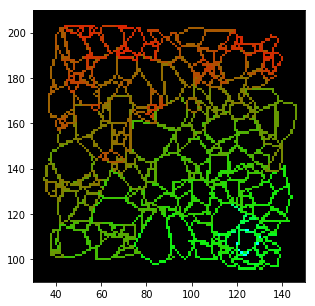

In [74]:
img = np.zeros((300,300,3), np.uint8)
XY = []
Crown_perimeter = []
for t in range(219):
    a = t
    b = 255 - a
    c = int(255/(t+1))
    XY = []
    for j, index in enumerate(open('output_multilayer2/multilayers_2_ALS(TLS)_segmentation.txt', 'r').readlines()[start[t]+1:end[t]]):
        x = []
        y = []
        w = index.split(',')
        x.append(float(w[0]))
        y.append(float(w[1].strip()))
        x.extend(y)
        XY.append(x)
    ploygon =np.array(XY, np.int32)
    pts = ploygon.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(a,b,c))
    distance_sum = 0
    distance_close =  sqrt( (XY[-1][0] - XY[0][0])**2 + (XY[-1][1] - XY[0][1])**2 )
    for i in range(len(XY)-1):
        distance = sqrt( (XY[i+1][0] - XY[i][0])**2 + (XY[i+1][1] - XY[i][1])**2 )
        distance_sum = distance_sum + distance
    distance_sum = distance_sum + distance_close
    perimeter = distance_sum
    Crown_perimeter.append(perimeter)
plt.figure(figsize=(5,5))
plt.axis([30,150,90,210])
plt.imshow(img)

In [30]:
plt.imsave('output_multilayer2/multilayers_2_ALS(TLS)_1.tif',img[90:210,30:150])

In [19]:
import pandas as pd
import numpy as np

In [23]:
import pandas as pd
import numpy as np
H = []
TOP_X = []
TOP_Y = []
for i, t in enumerate(trees):
    x, y, z = [], [], []
    for p in t:
        x.append(p[X])
        y.append(p[Y])
        z.append(p[Z])
    max_z = np.max(z)
    min_z = np.min(z)
    height = max_z - min_z
    num = z.index(max_z)
    top_x = x[num]
    top_y = y[num]
    H.append(height)
    TOP_X.append(top_x)
    TOP_Y.append(top_y)
TOP_X = np.array(TOP_X)
TOP_Y = np.array(TOP_Y)

df = pd.DataFrame({"TOP_X" : TOP_X, "TOP_Y": TOP_Y})
df.to_csv("TOP_POINT.csv", index=False)


In [26]:
H = np.array(H)
df = pd.DataFrame({"H" : H})
df.to_csv("Height.csv", index=False)

Calculate the DBH by using the linear regression between CP and DBH

In [20]:
DBH = []
for i in range(len(Crown_perimeter)):
    
    if Crown_perimeter[i] >= 10:
        dbh = 2.04*Crown_perimeter[i]-17.25 
        DBH.append(dbh)
    else:
        dbh = 0.43*Crown_perimeter[i] + 2.48
        DBH.append(dbh)
    print 'tree:',i+1,'   DBH:',DBH[i],'cm'
DBH = np.array(DBH)
df = pd.DataFrame({"DBH" : DBH})
df.to_csv("DBH.csv", index=False)

tree: 1    DBH: 48.2015174184 cm
tree: 2    DBH: 75.2025682628 cm
tree: 3    DBH: 35.9647457896 cm
tree: 4    DBH: 14.732633092 cm
tree: 5    DBH: 35.8345855 cm
tree: 6    DBH: 42.4720967904 cm
tree: 7    DBH: 25.8831789574 cm
tree: 8    DBH: 12.6074766996 cm
tree: 9    DBH: 18.0811583802 cm
tree: 10    DBH: 5.68574856393 cm
tree: 11    DBH: 31.7523302733 cm
tree: 12    DBH: 11.9315616146 cm
tree: 13    DBH: 18.575890792 cm
tree: 14    DBH: 109.851088618 cm
tree: 15    DBH: 26.7441327709 cm
tree: 16    DBH: 33.0719076749 cm
tree: 17    DBH: 45.4553651328 cm
tree: 18    DBH: 85.5297287087 cm
tree: 19    DBH: 51.9079121986 cm
tree: 20    DBH: 15.4400925851 cm
tree: 21    DBH: 19.03562974 cm
tree: 22    DBH: 52.2843745044 cm
tree: 23    DBH: 4.76605192372 cm
tree: 24    DBH: 51.5373998663 cm
tree: 25    DBH: 44.6562032509 cm
tree: 26    DBH: 5.91214885206 cm
tree: 27    DBH: 32.9748330446 cm
tree: 28    DBH: 29.0313490245 cm
tree: 29    DBH: 5.86286690919 cm
tree: 30    DBH: 35.3352239022

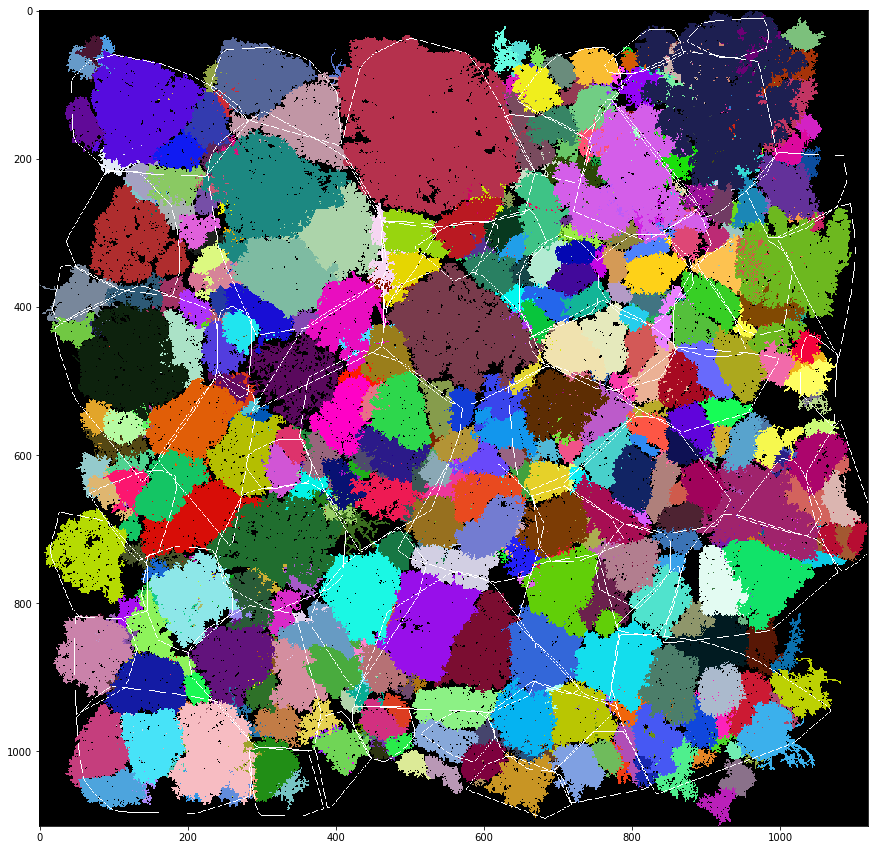

In [78]:
img = cv2.imread("raster.tif", cv2.IMREAD_UNCHANGED)
im = cv2.flip(img,0)

XY = []

for t in range(60):
    a = 255
    b = 255
    c = 255
    XY = []
    for j, index in enumerate(open('output_multilayer0/multilayers_0_ALS(TLS)_segmentation.txt', 'r').readlines()[start[t]+1:end[t]]):
        x = []
        y = []
        w = index.split(',')
        x.append(float(w[0])*10-340)
        y.append(float(w[1].strip())*10-950)
        x.extend(y)
        XY.append(x)
    ploygon =np.array(XY, np.int32)
    pts = ploygon.reshape((-1,1,2))
    cv2.polylines(im,[pts],True,(a,b,c))
plt.figure(figsize=(15,15))
plt.imshow(im)

In [79]:
plt.imsave('output_multilayer2/multil_ALS_cut.png',im)

In [17]:
#plt.imsave('output_multilayer0/multilayers_1_ALS(TLS)_segmentation.tif',img[90:210,30:150])